# Value of Time and Modal Distributions
-----
This notebook is largely exploratory into time savings and HOV v SOV distributions

In [1]:
suppressWarnings(library(tidyverse))
library(RSQLCipher)
library(lubridate)
library(nlme)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date


Attaching package: ‘nlme’

The following object is masked from ‘package:dplyr’:

    collapse



In [2]:
Sys.setenv("SQL_KEY"=Sys.getenv("HOT_KEY"))
db_path = "../../../db/hot-v3.db"

In [3]:
trips_2pct <- load_table(db_path, "trips_2pct")
trips_linked <- load_table(db_path, "trips_linked")

corridor_start_trips <- trips_linked %>%
    select(trip_id,
          toll,
          is_hov,
          id,
           def_id,
          entry_time,
          entry_plaza,
           exit_plaza)%>%
    filter(entry_plaza == 4 | entry_plaza == 3) %>%
    execute

trip_time <- read.csv("../../../data/allNBMod.csv")

In [4]:
corridor_start_trips$entry_time <- as_datetime(corridor_start_trips$entry_time, tz = "UTC")
corridor_start_trips$date_time <- format(as.POSIXct(corridor_start_trips$entry_time, format="%Y:%m:%d %H:%M:%S"),"%m%d%H%M")
corridor_start_trips$five_min <- floor(as.numeric(corridor_start_trips$date_time) / 5) * 5
corridor_start_trips$min <- floor(as.numeric(corridor_start_trips$date_time))
corridor_start_trips$is_hov[corridor_start_trips$toll != 0] <- 0
corridor_start_trips$is_hov[corridor_start_trips$toll == 0] <- 1

In [5]:
corridor_time <- trip_time %>%
    select(X2734GP, 
           X2734_ST,
           X2734HOV,
          date_time) %>%
    rename(gp = X2734GP,
          savings = X2734_ST,
          hot = X2734HOV,
          trip_date_time = date_time)

corridor_time$five_min <- format(as.POSIXct(corridor_time$trip_date_time, format="%Y-%m-%d %H:%M:%S"),"%m%d%H%M")
corridor_time$five_min <- floor(as.numeric(corridor_time$five_min) / 5) * 5

In [6]:
corridor_start_trip_times <- merge(corridor_start_trips, corridor_time, by = "five_min", all = FALSE)
corridor_start_trip_times$five_min <- as.numeric(corridor_start_trip_times$five_min)

## First-Pass VOT

In [7]:
value_of_time <- corridor_start_trip_times %>%
    filter(exit_plaza == 12,
          is_hov == 0) %>%
    mutate(vot = ( savings / 60 ) / toll,
          hour_min = five_min %% 10000) 

### Value of Time by Time of Day
The first pass value of time is the savings divided by the toll

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 14892 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 14892 rows containing missing values (geom_point).”

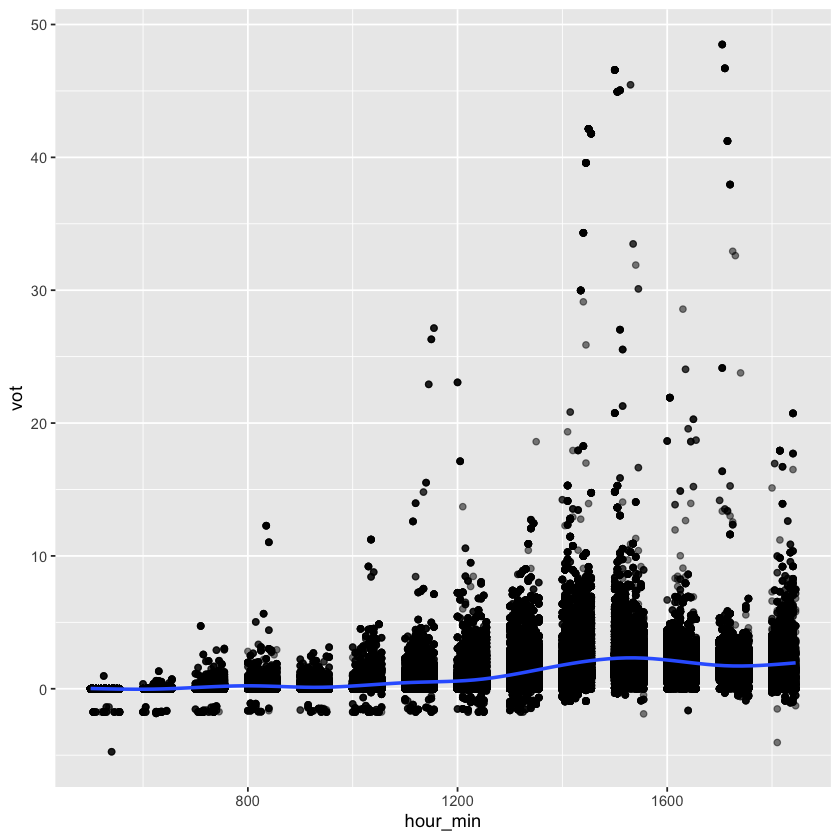

In [8]:
ggplot(value_of_time, aes(x = hour_min, y = vot)) +
    geom_point(alpha = .5) +
    geom_smooth()

## Volume

In [9]:
five_min <- corridor_start_trip_times %>%
    mutate(vot = ( savings / 60 ) / toll,
          hour_min = five_min %% 10000) 

five_min$vot[five_min$exit_gate != 12] <- NA

five_min$is_hov[five_min$toll == 0] <- 1

five_min_agg <- five_min %>%
    group_by(five_min) %>%
    summarize(toll = median(toll),
              total_vol = n(),
              savings = median(savings),
              sov_vol = total_vol - sum(is_hov),
              hov_vol = sum(is_hov),
             hour_min = median(hour_min),
             vot = mean(!is.na(vot)))

five_min_agg$sov_vol[is.na(five_min$sov_vol)] <- 0

## Savings by Toll

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 1478 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 1478 rows containing missing values (geom_point).”

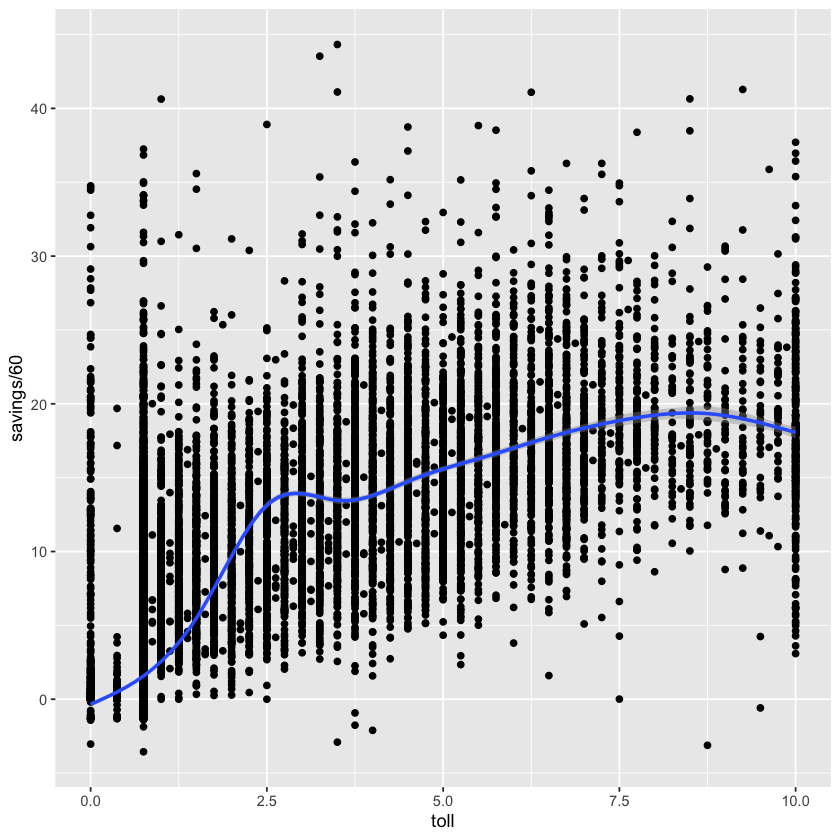

In [10]:
five_min_agg %>%
ggplot(aes(x = toll, y = savings / 60)) +
    geom_point() +
    geom_smooth()

## Entry by Toll, grouped by mode

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


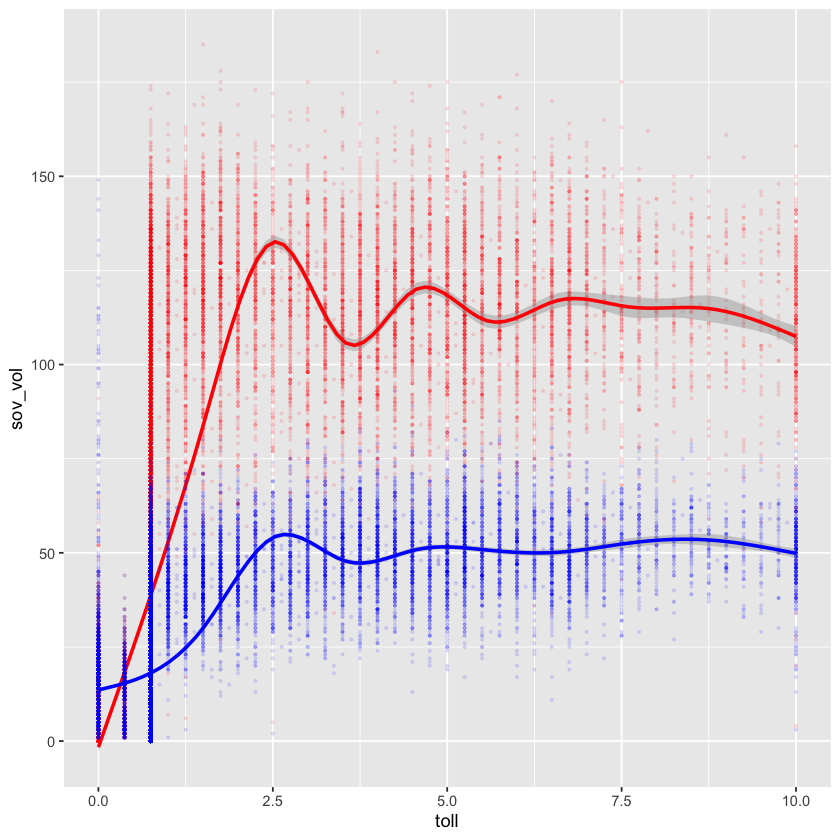

In [11]:
five_min_agg %>%
ggplot(aes(x = toll)) +
    geom_point(aes(y = sov_vol), color = "red", size = .5, alpha = .1) +
    geom_smooth(aes(y = sov_vol), color = "red") +
    geom_point(aes(y = hov_vol), color = "blue", size = .5, alpha = .1) +
    geom_smooth(aes(y = hov_vol), color = "blue")

## Entry by Time, grouped by Mode

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


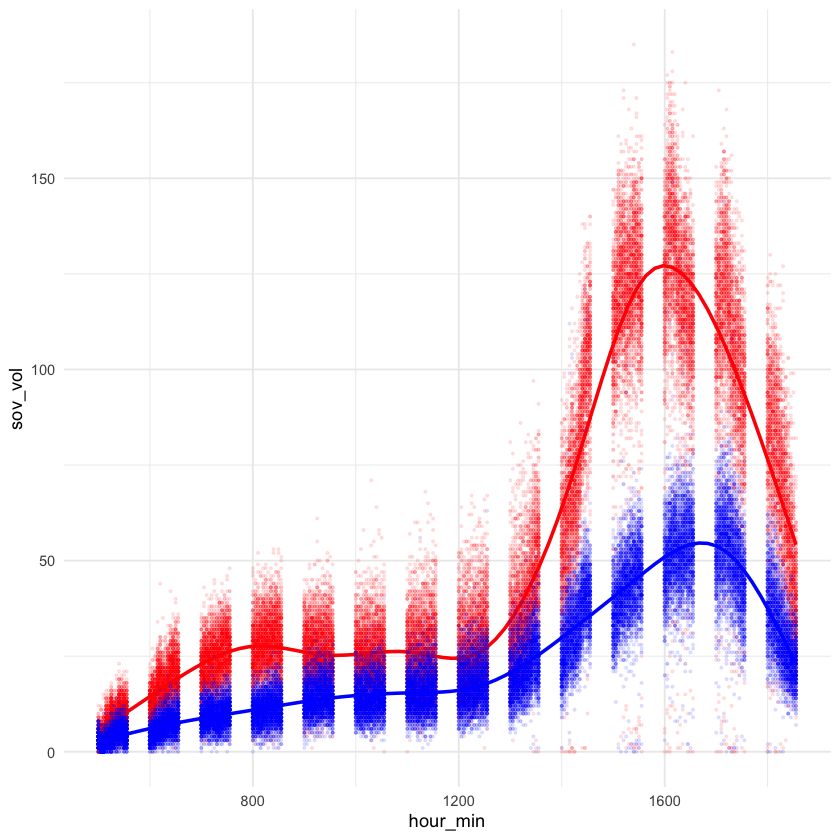

In [12]:
five_min_agg %>%
ggplot(aes(x = hour_min)) +
    geom_point(aes(y = sov_vol), color = "red", size = .5, alpha = .1) +
    geom_smooth(aes(y = sov_vol), color = "red") +
    geom_point(aes(y = hov_vol), color = "blue", size = .5, alpha = .1) +
    geom_smooth(aes(y = hov_vol), color = "blue") +
    theme_minimal()

## Total Volume by Toll

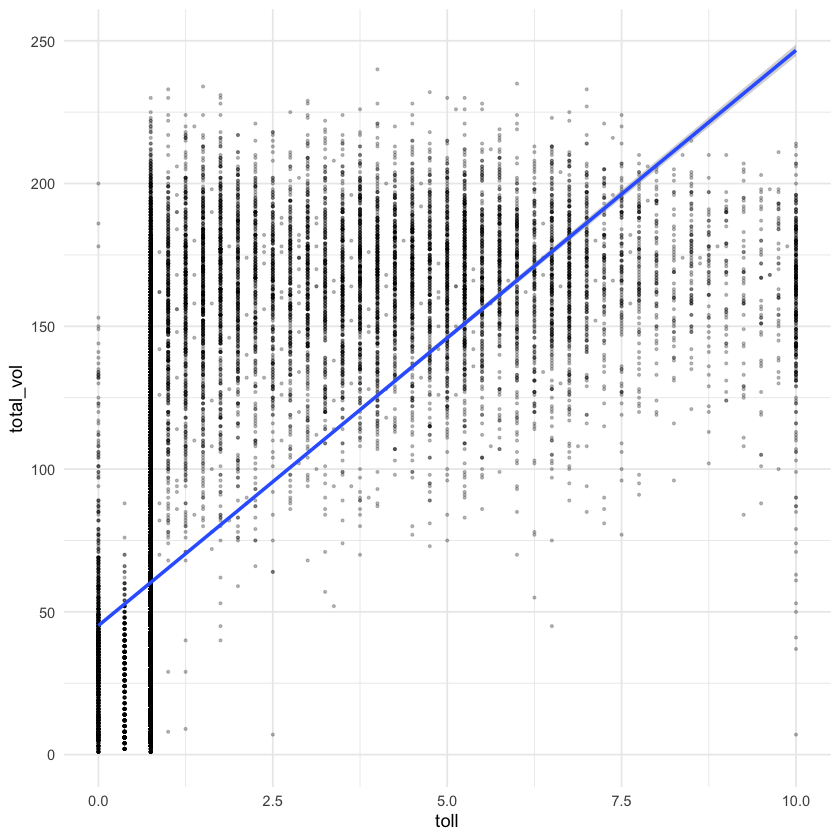

In [13]:
ggplot(five_min_agg, aes(x = toll, y = total_vol)) +
    geom_point(size = .5, alpha = .25) +
    geom_smooth(method = "lm") +
    theme_minimal()

## Savings by Toll

Warning message:
“Removed 1478 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 1478 rows containing missing values (geom_point).”

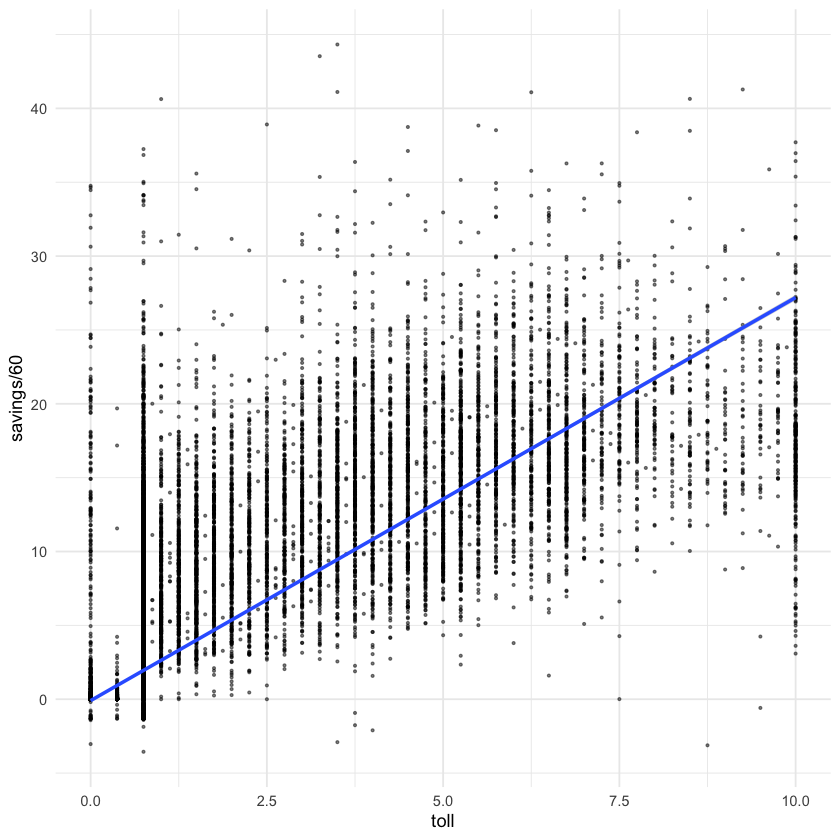

In [14]:
ggplot(five_min_agg, aes(x = toll , y = savings / 60)) +
    geom_point(size = .5, alpha = .5) +
    geom_smooth(method = "lm") +
    theme_minimal()

# Comparing range of savings over toll

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


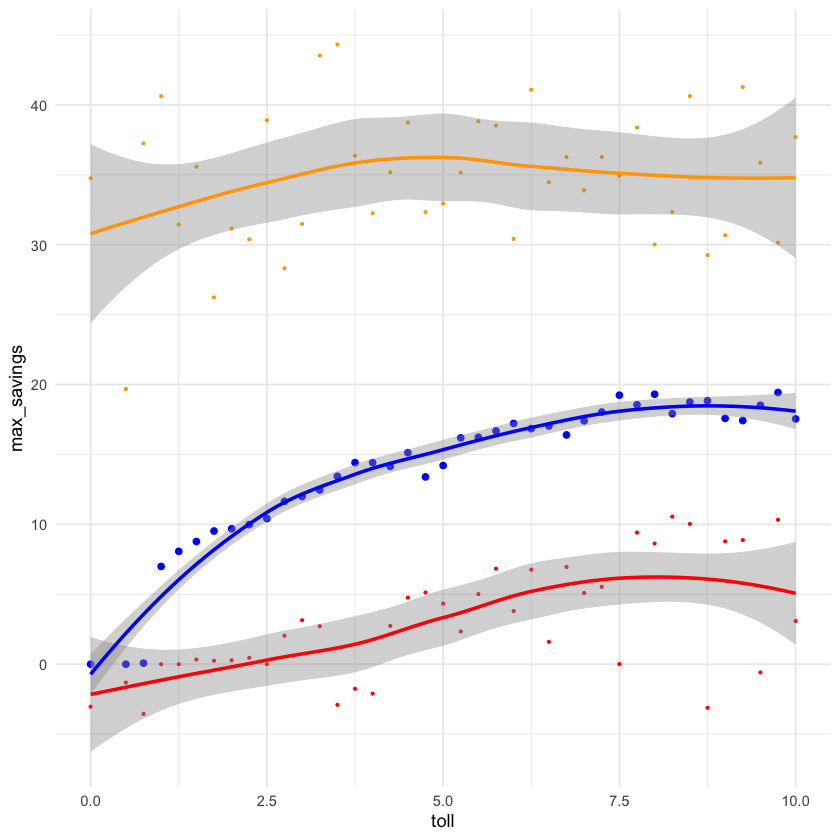

In [15]:
plot <- five_min_agg

plot$toll <- round(plot$toll / .25) * .25

plot <- plot %>%
    group_by(toll) %>%
    na.omit() %>%
    summarize(max_savings = max(savings / 60),
             min_savings = min(savings / 60),
             median_savings = median(savings / 60))

ggplot(plot, aes(x = toll)) +
    geom_point(aes(y = max_savings), color = "orange", size = .5) +
    geom_point(aes(y = min_savings), color = "red", size = .5) +
    geom_point(aes(y = median_savings), color = "blue") +
    geom_smooth(aes(y = max_savings), color = "orange") +
    geom_smooth(aes(y = min_savings), color = "red") +
    geom_smooth(aes(y = median_savings), color = "blue") +
    theme_minimal()

## Difference between maximum and minimum savings at each toll

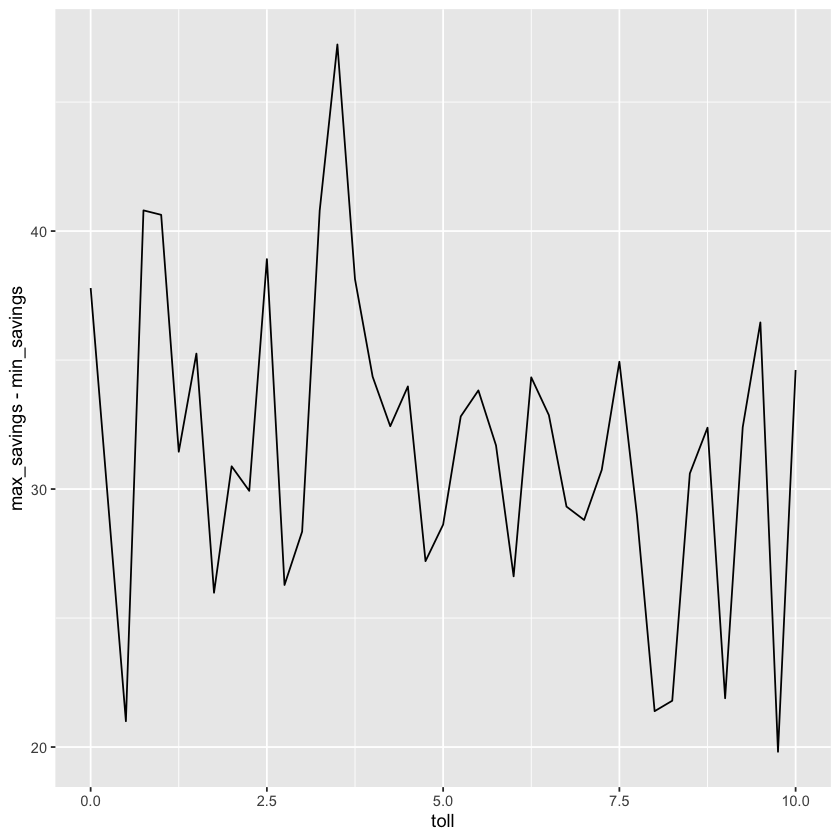

In [16]:
ggplot(plot, aes(x = toll, y = max_savings - min_savings)) +
    geom_line()

## Very simple regression

In [17]:
#biased regression based off of unobservables
summary(lm(sov_vol ~ toll + hov_vol + savings, five_min_agg))


Call:
lm(formula = sov_vol ~ toll + hov_vol + savings, data = five_min_agg)

Residuals:
     Min       1Q   Median       3Q      Max 
-255.953   -9.171   -1.728    7.241   92.096 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 5.3505513  0.1737965   30.79   <2e-16 ***
toll        1.2119031  0.0779390   15.55   <2e-16 ***
hov_vol     1.6685111  0.0086723  192.40   <2e-16 ***
savings     0.0192415  0.0004813   39.98   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 18.13 on 41334 degrees of freedom
  (1478 observations deleted due to missingness)
Multiple R-squared:  0.8002,	Adjusted R-squared:  0.8002 
F-statistic: 5.517e+04 on 3 and 41334 DF,  p-value: < 2.2e-16


## Modal Distributions

In [18]:
modal <- trips_linked %>%
    select(is_hov,
          entry_time, 
           entry_plaza,
           exit_plaza,
          toll) %>%
    filter(entry_plaza == 4 | entry_plaza == 3 | entry_plaza == 12 | entry_plaza == 13) %>%
    execute

modal$is_hov[modal$toll == 0] <- 1
modal$is_hov[modal$toll != 0] <- 0

modal$entry_time <- as_datetime(modal$entry_time, tz = "UTC")
modal$date_time <- format(as.POSIXct(modal$entry_time, format="%Y:%m:%d %H:%M:%S"),"%m%d%H%M")
modal$five_min <- floor(as.numeric(modal$date_time) / 5) * 5

five_min_modal <- modal %>%
    mutate(hour_min = five_min %% 10000) %>%
    group_by(five_min) %>%
    summarize(sov_entry = n() - sum(is_hov),
              hov_entry = sum(is_hov),
              total_entry = n(),
             hour_min = median(hour_min))

In [19]:
max(modal$five_min)

[1] 12311855

### Distribution by Time of Day

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


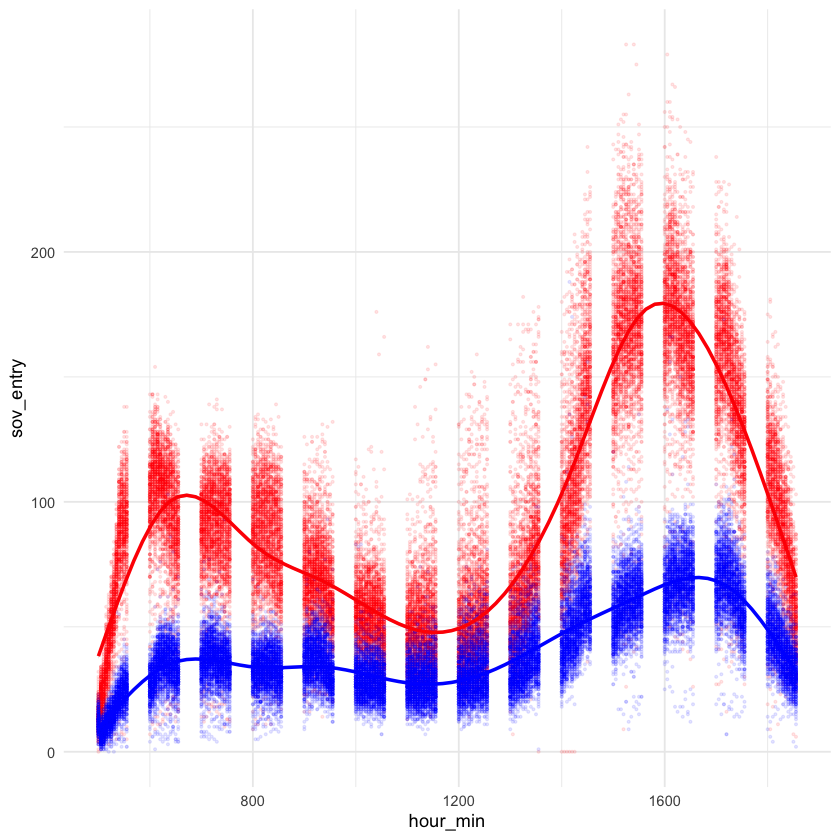

In [20]:
ggplot(five_min_modal, aes(x = hour_min)) +
    geom_point(aes(y = sov_entry), color = "red", size = .5, alpha = .1) +
    geom_point(aes(y = hov_entry), color = "blue", size = .5, alpha = .1) +
    geom_smooth(aes(y = sov_entry), color = "red") +
    geom_smooth(aes(y = hov_entry), color = "blue") +
    theme_minimal()

### Distribution by Frequency

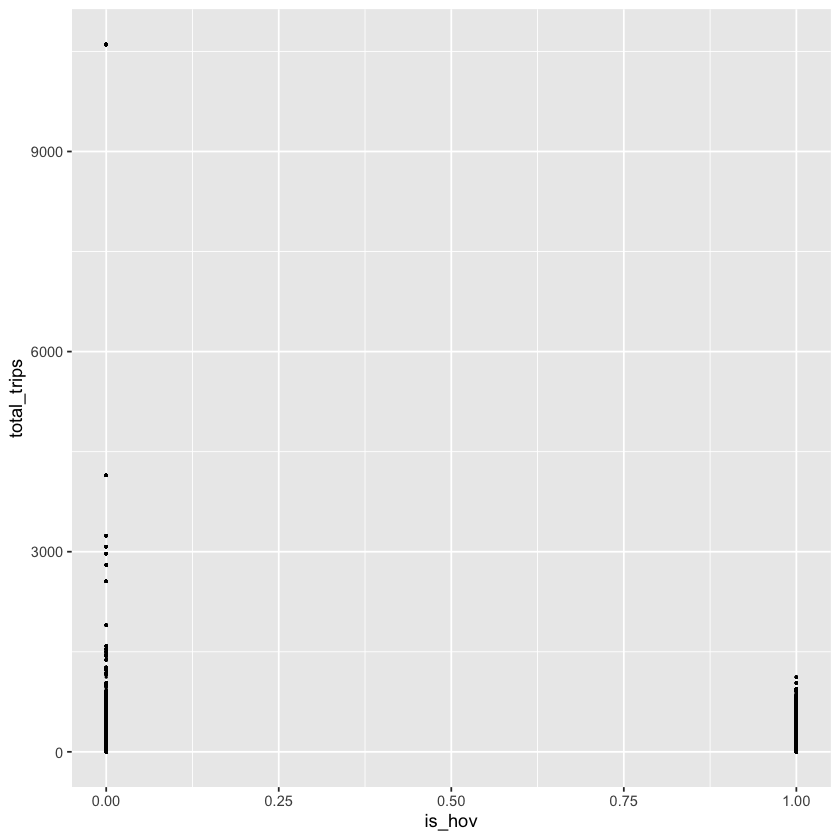

In [21]:
hov_freq <- trips_2pct %>%
    select(is_hov, trip_id, total_trips, freq, toll, commercial) %>%
    filter(commercial != 1) %>%
    execute

hov_freq %>%
    #group_by(freq) %>%
    #summarize(mean_hov = mean(is_hov)) %>%
ggplot(aes(x = is_hov, y = total_trips)) +
    geom_point(size = .25)

## Gross Replication

In [22]:
#finding travel time savings
one_min_regress <- five_min %>%
    filter(exit_plaza == 12,
          is_hov == 0) %>%
    group_by(hour_min) %>%
    na.omit() %>%
    mutate(reliability = (quantile(gp, .8) - median(gp)) - (quantile(hot, .8) - median(hot)))  %>%
    ungroup() %>%
    group_by(min) %>%
    summarize(est_time_savings = median(savings) / 60,
             reliability = median(reliability),
             sov_users = n(),
             toll = median(toll),
             hour = median(hour_min) %/% 100)

head(one_min_regress)

min,est_time_savings,reliability,sov_users,toll,hour
<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1020506,0,0,1,0.75,5
1020513,0,0,1,0.75,5
1020516,0,0,3,0.75,5
1020521,0,0,1,0.75,5
1020525,0,0,3,0.75,5
1020530,0,0,1,0.75,5
